In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from IG import information_gain, cal_entroy

In [2]:
dataset = pd.read_csv('./Nova_Scotia_Provincial_Ambient_Fine_Particulate_Matter__PM2.5__Hourly_Data_Halifax_BAM_T640.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140255 entries, 0 to 140254
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date & time  140255 non-null  object 
 1   Pollutant    140255 non-null  object 
 2   Unit         140255 non-null  object 
 3   Station      140255 non-null  object 
 4   Instrument   140255 non-null  object 
 5   Average      111765 non-null  float64
dtypes: float64(1), object(5)
memory usage: 6.4+ MB


In [3]:
dataset = dataset[dataset['Date & time'].apply(str).str.contains('2019')]
dataset['Date & time'] = pd.to_datetime(dataset['Date & time'])
data = dataset.groupby(dataset['Date & time'].dt.date)['Average'].sum().reset_index(name='PM2.5')
data.rename(columns={'Date & time': 'Date'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")

In [4]:
traffic = pd.read_csv('./Traffic_Volumes_-_Provincial_Highway_System.csv')

In [5]:
traffic = traffic[traffic['Date'].apply(str).str.contains('2019')].loc[traffic.COUNTY=='HFX']
traffic['Date'] = pd.to_datetime(traffic['Date'])

In [6]:
merged = traffic.merge(data, on='Date')
# normalization
merged['PM2.5'] = preprocessing.MinMaxScaler().fit_transform(np.array(merged['PM2.5']).reshape(-1,1))
merged['LEVEL'] = np.where(merged['PM2.5'] > 0.5, 'High', 'Low')
merged = merged.drop('PM2.5', axis=1)
merged.info()
merged = merged.drop(['SECTION DESCRIPTION', 'DESCRIPTION', 'PTRUCKS', 
                      '85PCT', 'PRIORITY_POINTS'], axis=1)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SECTION ID           168 non-null    int64         
 1   HIGHWAY              168 non-null    int64         
 2   SECTION              168 non-null    int64         
 3   SECTION LENGTH       168 non-null    float64       
 4   SECTION DESCRIPTION  168 non-null    object        
 5   Date                 168 non-null    datetime64[ns]
 6   DESCRIPTION          168 non-null    object        
 7   GROUP                168 non-null    object        
 8   TYPE                 168 non-null    object        
 9   COUNTY               168 non-null    object        
 10  PTRUCKS              42 non-null     float64       
 11  ADT                  162 non-null    float64       
 12  AADT                 168 non-null    float64       
 13  DIRECTION            102 non-null  

In [7]:
# fill missing values
merged.isnull().sum()
merged.DIRECTION = merged.DIRECTION.fillna('')
merged.ADT = merged.ADT.interpolate()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SECTION ID      168 non-null    int64         
 1   HIGHWAY         168 non-null    int64         
 2   SECTION         168 non-null    int64         
 3   SECTION LENGTH  168 non-null    float64       
 4   Date            168 non-null    datetime64[ns]
 5   GROUP           168 non-null    object        
 6   TYPE            168 non-null    object        
 7   COUNTY          168 non-null    object        
 8   ADT             168 non-null    float64       
 9   AADT            168 non-null    float64       
 10  DIRECTION       168 non-null    object        
 11  LEVEL           168 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 17.1+ KB


[('Date', 0.689874083566943), ('ADT', 0.6779693216621812), ('AADT', 0.6422550359478953), ('SECTION ID', 0.6117823247647779), ('SECTION LENGTH', 0.606694509453627), ('HIGHWAY', 0.3024631809924698), ('SECTION', 0.16634660029772208), ('GROUP', 0.06472106386262322), ('DIRECTION', 0.01060249502508126), ('TYPE', 5.6308412162753285e-05), ('COUNTY', 0.0)]


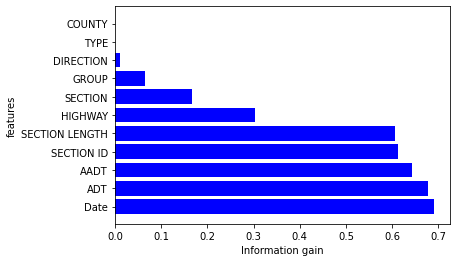

In [8]:
def entropy(data):
    prob = pd.value_counts(data) / len(data)
    return (-1) * sum(np.log2(prob) * prob)

def cal_information_gain(data, split_name, target_name):
    ent = data.groupby(split_name).apply(lambda x: entropy(x[target_name]))
    pro = pd.value_counts(data[split_name]) / len(data[split_name])
    weighted_ent = sum(ent * pro)
    return entropy(data[target_name]) - weighted_ent

def plot_graph(dataset):
    result = {}
    for col in dataset.iloc[:, :-1].columns:
        information_gain = cal_information_gain(dataset, col, 'LEVEL')
        result[col] = information_gain

    result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    print(result)
    plt.barh([x[0] for x in result],[x[1] for x in result], color="blue")
    plt.ylabel('features')
    plt.xlabel('Information gain')
    plt.show()
    
plot_graph(merged)

In [9]:
# select five features with the information gain in case more features will lead to overfitting
columns = ['Date', 'SECTION ID', 'SECTION LENGTH', 'ADT', 'AADT', 'LEVEL']
filted = merged[columns]
filted.head()

,Date,SECTION ID,SECTION LENGTH,ADT,AADT,LEVEL
0,2019-09-09,1047,4.50,2566.0,2430.0,Low
1,2019-09-12,101020,3.71,23205.0,22000.0,Low
2,2019-09-12,101020,3.71,23385.0,22100.0,Low
3,2019-09-12,101025,2.89,16023.0,15200.0,Low
4,2019-09-12,101025,2.89,16204.0,15300.0,Low


In [10]:
# deal with Date 
filted = filted.assign(Year=filted['Date'].dt.year)
filted = filted.assign(Month=filted['Date'].dt.month)
filted = filted.assign(Day=filted['Date'].dt.day)
final = filted.drop('Date', axis=1)
final = final[[ col for col in final.columns if col != 'LEVEL' ] 
              + ['LEVEL']]

# encoder target column
final['LEVEL'] = final['LEVEL'].map(dict(High=1, Low=0))
final.head()

,SECTION ID,SECTION LENGTH,ADT,AADT,Year,Month,Day,LEVEL
0,1047,4.50,2566.0,2430.0,2019,9,9,0
1,101020,3.71,23205.0,22000.0,2019,9,12,0
2,101020,3.71,23385.0,22100.0,2019,9,12,0
3,101025,2.89,16023.0,15200.0,2019,9,12,0
4,101025,2.89,16204.0,15300.0,2019,9,12,0


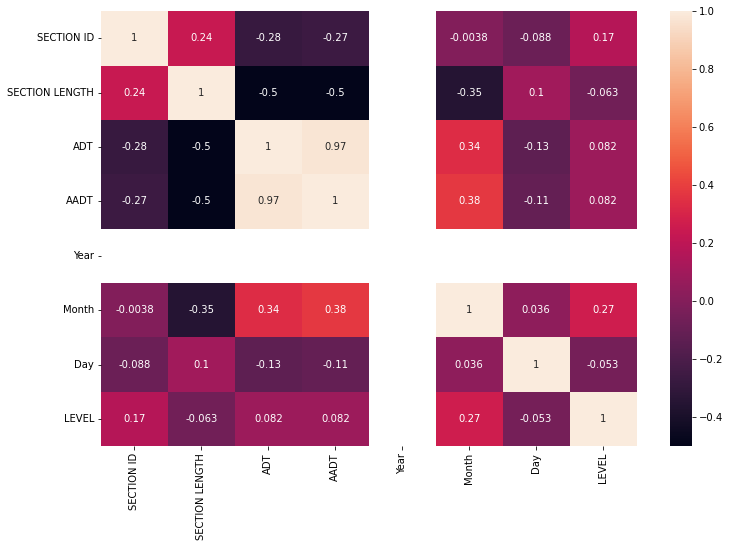

In [11]:
fig_dim = (12, 8)
fig, ax = plt.subplots(figsize=fig_dim)
sns.heatmap(final.corr(), ax=ax, annot=True)
plt.show()

[('ADT', 0.6779693216621812), ('AADT', 0.6422550359478953), ('SECTION ID', 0.6117823247647779), ('SECTION LENGTH', 0.606694509453627), ('Day', 0.5280688058247365), ('Month', 0.32872079866577636), ('Year', 0.0)]


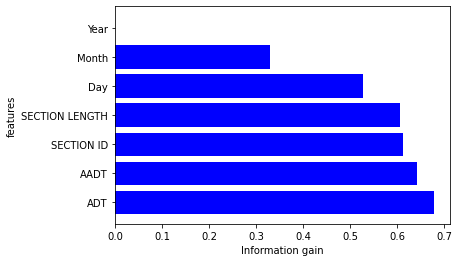

In [12]:
plot_graph(final)

In [13]:
final = final.drop(['Month', 'Year'], axis=1)
final.head()

,SECTION ID,SECTION LENGTH,ADT,AADT,Day,LEVEL
0,1047,4.50,2566.0,2430.0,9,0
1,101020,3.71,23205.0,22000.0,12,0
2,101020,3.71,23385.0,22100.0,12,0
3,101025,2.89,16023.0,15200.0,12,0
4,101025,2.89,16204.0,15300.0,12,0


In [14]:
x = final.iloc[:, :-1]
y = final.iloc[:, -1]
print(x.head())
print(y.head())

   SECTION ID  SECTION LENGTH      ADT     AADT  Day
0        1047            4.50   2566.0   2430.0    9
1      101020            3.71  23205.0  22000.0   12
2      101020            3.71  23385.0  22100.0   12
3      101025            2.89  16023.0  15200.0   12
4      101025            2.89  16204.0  15300.0   12
0    0
1    0
2    0
3    0
4    0
Name: LEVEL, dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, 
                                                    random_state=42)
X_train.shape, X_test.shape

((84, 5), (84, 5))

In [16]:
y_train.shape, y_test.shape

((84,), (84,))

[Text(0.4583333333333333, 0.875, 'ADT <= 4202.0\nentropy = 0.65\nsamples = 84\nvalue = [70, 14]\nclass = 0'),
 Text(0.25, 0.625, 'Day <= 8.5\nentropy = 0.183\nsamples = 36\nvalue = [35, 1]\nclass = 0'),
 Text(0.16666666666666666, 0.375, 'Day <= 5.0\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = 0'),
 Text(0.08333333333333333, 0.125, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = 0'),
 Text(0.25, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(0.3333333333333333, 0.375, 'entropy = 0.0\nsamples = 32\nvalue = [32, 0]\nclass = 0'),
 Text(0.6666666666666666, 0.625, 'SECTION ID <= 118016.5\nentropy = 0.843\nsamples = 48\nvalue = [35, 13]\nclass = 0'),
 Text(0.5, 0.375, 'SECTION ID <= 103042.5\nentropy = 0.722\nsamples = 40\nvalue = [32, 8]\nclass = 0'),
 Text(0.4166666666666667, 0.125, 'entropy = 0.837\nsamples = 30\nvalue = [22, 8]\nclass = 0'),
 Text(0.5833333333333334, 0.125, 'entropy = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = 0'),
 Text(0.833333333

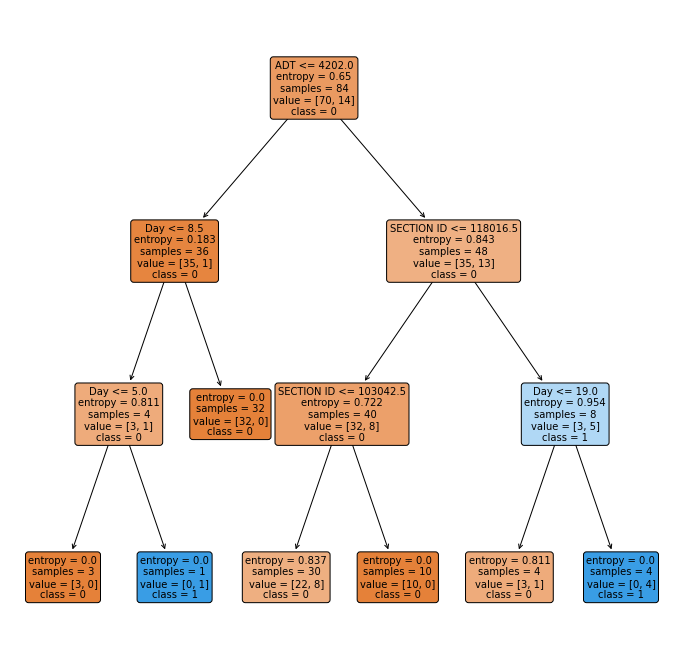

In [17]:
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                    random_state=42)
# fit the model
classifier.fit(X_train, y_train)
# plot the decision tree
plt.figure(figsize=(12,12))
tree.plot_tree(classifier,  feature_names=X_train.columns, 
class_names = np.array(y_train.unique()).astype('str').tolist(), 
filled=True, 
rounded=True, impurity=True, fontsize=10)

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[63,  4],
       [12,  5]])

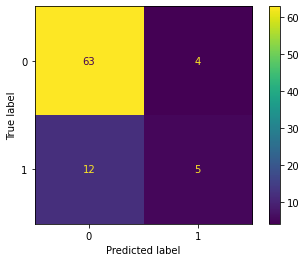

In [19]:
graph_confusion = ConfusionMatrixDisplay(confusion_matrix=cm, 
                display_labels=classifier.classes_)
graph_confusion.plot()
plt.show()

In [20]:
# decision tree classification report
decision_report = classification_report(y_test, y_pred)
print(decision_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        67
           1       0.56      0.29      0.38        17

    accuracy                           0.81        84
   macro avg       0.70      0.62      0.64        84
weighted avg       0.78      0.81      0.79        84



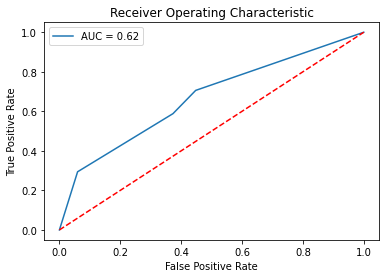

In [21]:
# ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
dt_roc_auc = roc_auc_score(y_test, y_pred)
dt_fpr, dt_tpr, td_threshold = roc_curve(y_test, 
        classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(dt_fpr, dt_tpr, label='AUC = %0.2f' % dt_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [22]:
# 10-fold cross-validation and model DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=False)
accuracy = cross_val_score(estimator = classifier, X = X_train, 
                           y = y_train, cv = cv)
print(accuracy)
print( "the average accuracy is {}".format(accuracy.mean()))
print("the standard deviation is {}".format(accuracy.std()))

[0.66666667 0.77777778 0.66666667 0.77777778 0.875      0.75
 0.875      0.875      0.875      0.875     ]
the average accuracy is 0.8013888888888889
the standard deviation is 0.08194444444444446


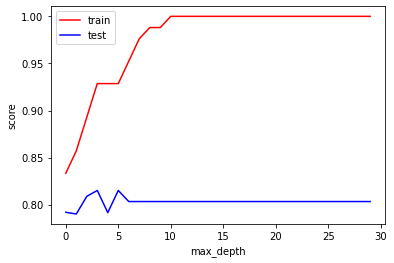

In [23]:
# model with different max_depth
trainScore = []
testScore = []
for i in range(30):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=i+1, 
                                random_state=0)
    dt.fit(X_train, y_train)
    train_score = dt.score(X_train, y_train)
    test_score = cross_val_score(dt, x, y, cv = 10).mean()
    trainScore.append(train_score)
    testScore.append(test_score)
plt.figure()
plt.plot(trainScore, color='red', label="train")
plt.plot(testScore, color='blue', label="test")
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

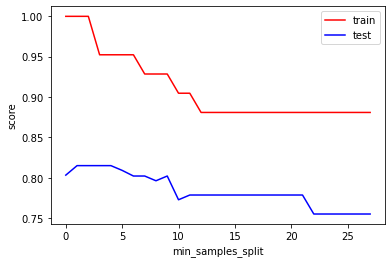

In [24]:
# model with min_samples_split
trainScore1 = []
testScore1 = []
for i in range(2, 30):
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, 
                                random_state=0)
    dt.fit(X_train, y_train)
    train_score = dt.score(X_train, y_train)
    test_score = cross_val_score(dt, x, y, cv = 10).mean()
    trainScore1.append(train_score)
    testScore1.append(test_score)
plt.figure()
plt.plot(trainScore1, color='red', label="train")
plt.plot(testScore1, color='blue', label="test")
plt.legend()
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

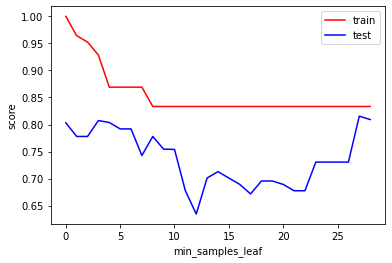

In [25]:
# model with min_samples_leaf
trainScore2 = []
testScore2 = []
for i in range(1, 30):
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, 
                                random_state=0)
    dt.fit(X_train, y_train)
    train_score = dt.score(X_train, y_train)
    test_score = cross_val_score(dt, x, y, cv = 10).mean()
    trainScore2.append(train_score)
    testScore2.append(test_score)
plt.figure()
plt.plot(trainScore2, color='red', label="train")
plt.plot(testScore2, color='blue', label="test")
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.show()

In [26]:
# 10-fold cross-validation and model RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=False)
model = RandomForestClassifier(criterion='entropy', random_state = 0)
model.fit(x, y)
accuracy = cross_val_score(estimator = model, X = x, y = y, cv = cv)
print( "the average accuracy is {}".format(accuracy.mean()))
print("the standard deviation is {}".format(accuracy.std()))

the average accuracy is 0.7727941176470589
the standard deviation is 0.18747693053004913


In [27]:
confusion_matrix_all = []

for train_index, test_index in cv.split(x, y):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    confusion = confusion_matrix(y_test, model.predict(X_test))
    confusion_matrix_all.append(confusion)
    
confusion_matrix_all

[array([[13,  1],
        [ 3,  0]]),
 array([[11,  3],
        [ 3,  0]]),
 array([[14,  0],
        [ 3,  0]]),
 array([[7, 7],
        [3, 0]]),
 array([[13,  1],
        [ 2,  1]]),
 array([[14,  0],
        [ 2,  1]]),
 array([[14,  0],
        [ 0,  3]]),
 array([[13,  0],
        [ 0,  4]]),
 array([[7, 6],
        [2, 1]]),
 array([[13,  0],
        [ 2,  1]])]

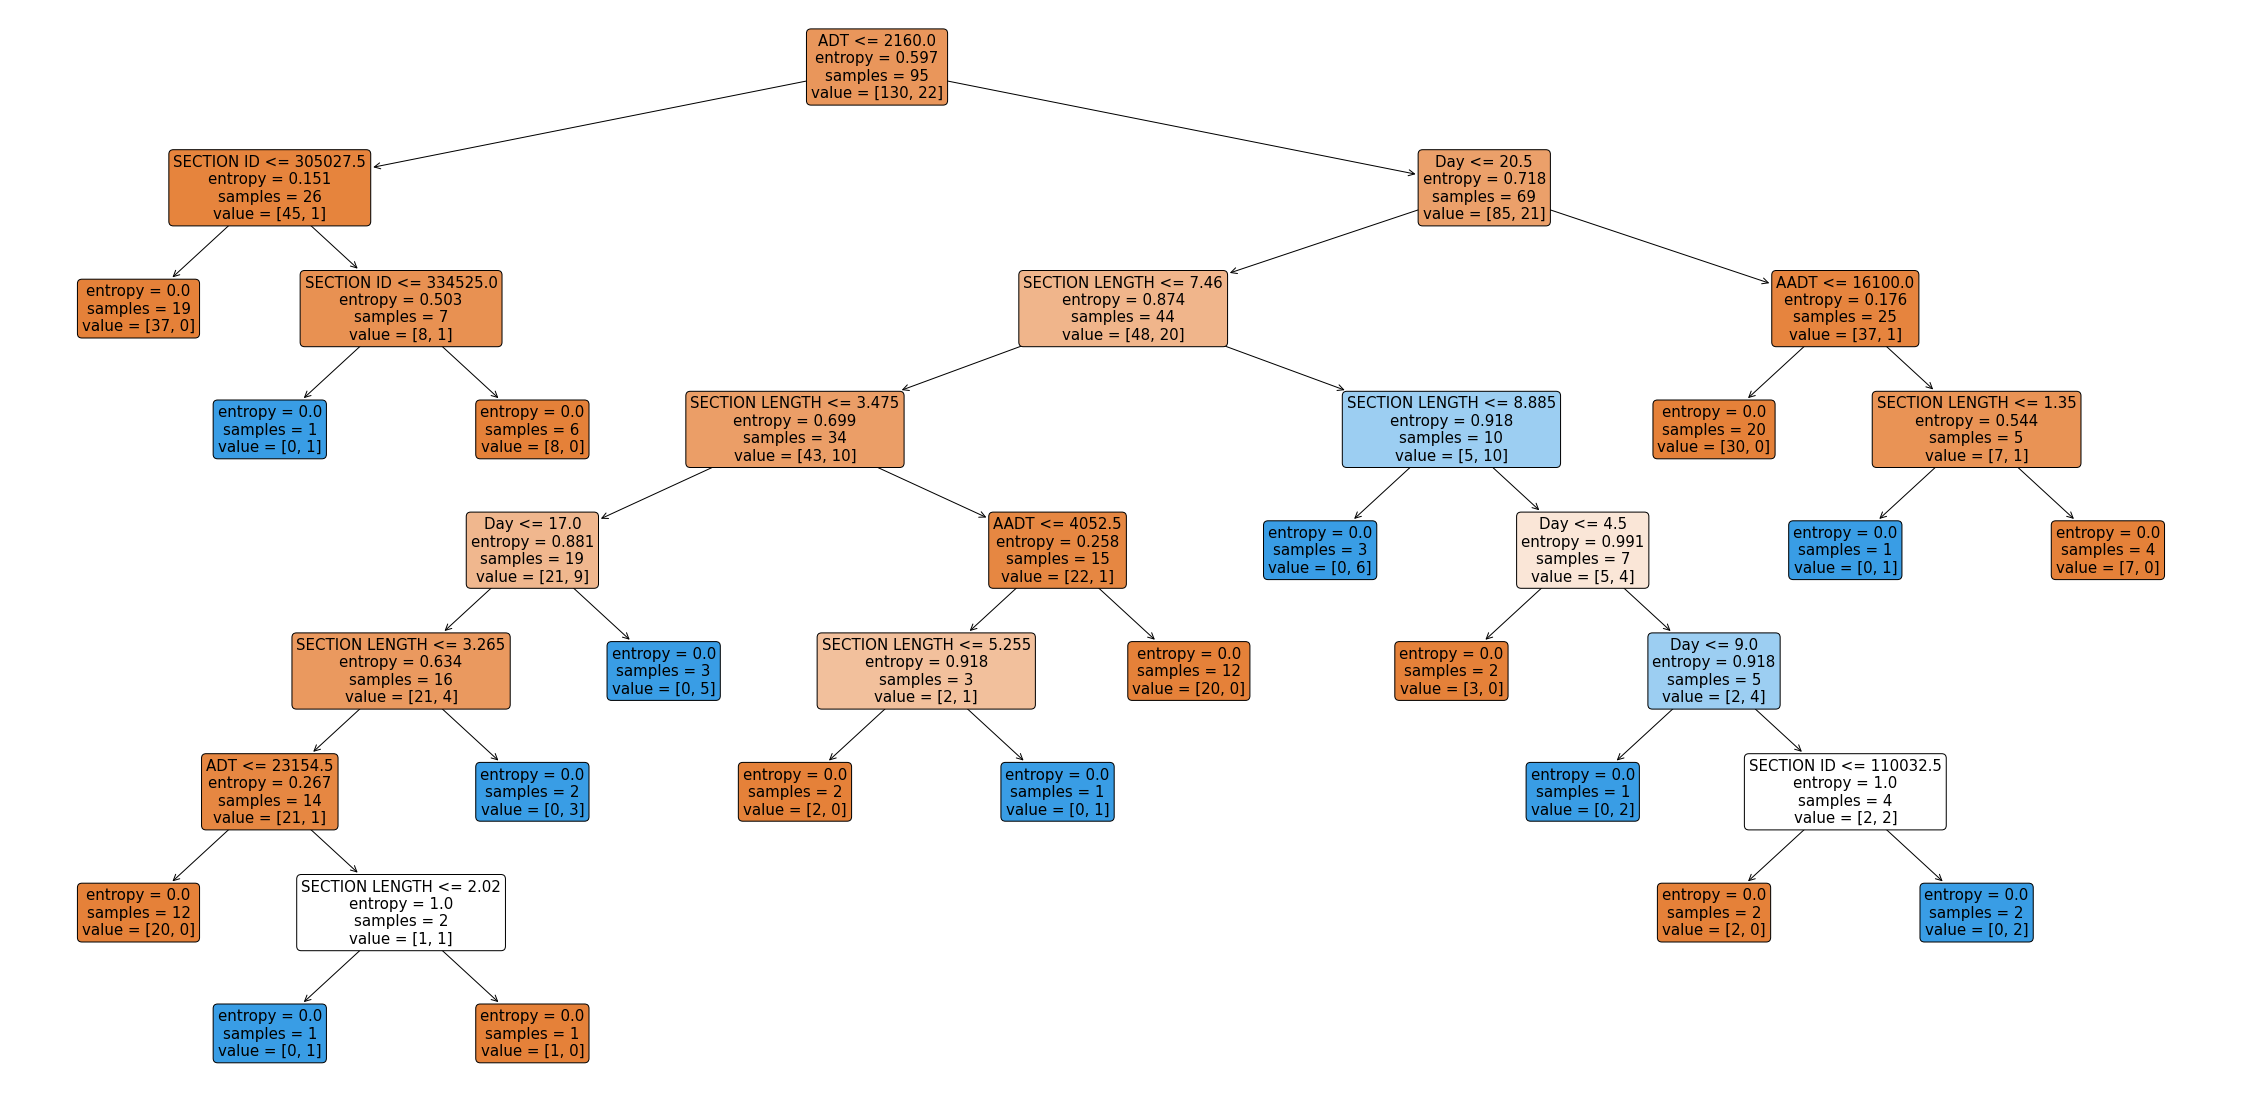

In [28]:
plt.figure(figsize=(40,20))
tree.plot_tree(model.estimators_[0], feature_names=X_train.columns, 
               filled=True, rounded=True, fontsize=15)
plt.show()